This runs all segmentation operations in one place.
The idea is that this should be faster and easier to envoke as we only have to load the image data once instead of N times (~10).
Running each individual task as its own script is modular but requires overhead to load the data each time.
Currently it takes about 15 minutes to complete a single organoid's segmentation for all compartments... (~50,1500,1500) (Z,Y,X) dimensional image. 
Let us see how long this takes!

No we are at ~8 minutes!

In [1]:
import argparse
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook
from nuclei_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

from segmentation_utils import *

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0037_T1-Z-1"
    well_fov = "F4-1"
    window_size = 3
    clip_limit = 0.03
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
return_dict = read_in_channels(find_files_available(input_dir))
nuclei = return_dict["nuclei"]
# run clip_limit here
nuclei = skimage.exposure.equalize_adapthist(
    nuclei, clip_limit=clip_limit, kernel_size=None
)

Unknown channel: /home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0037_T1-Z-1/zstack_images/F4-1/cell_masks.tiff
Unknown channel: /home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0037_T1-Z-1/zstack_images/F4-1/cytoplasm_masks.tiff
Unknown channel: /home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0037_T1-Z-1/zstack_images/F4-1/nuclei_masks.tiff
Unknown channel: /home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0037_T1-Z-1/zstack_images/F4-1/organoid_masks.tiff


## Nuclei Segmentation

In [6]:
nuclei_image_shape = nuclei.shape
#
nuclei_masks = np.array(
    list(  # send to array
        decouple_masks(  # 4. decouple masks
            reverse_sliding_window_max_projection(  # 3. reverse sliding window
                segmentaion_on_two_D(  # 2. segment on 2D
                    sliding_window_two_point_five_D(  # 1. run sliding window
                        image_stack=nuclei, window_size=3
                    )
                ),
                window_size=3,
                original_z_slice_count=nuclei_image_shape[0],
            ),
            original_img_shape=nuclei_image_shape,
            distance_threshold=10,
        ).values()
    )
)

100%|██████████| 61/61 [02:09<00:00,  2.13s/it]
63it [00:11,  5.50it/s]


In [7]:
# generate the coordinates dataframe for reconstruction
coordinates_df = generate_coordinates_for_reconstruction(nuclei_masks)
# generate distance pairs dataframe
df = generate_distance_pairs(coordinates_df, x_y_vector_radius_max_constraint=20)
# generate and solve graph to get longest paths
longest_paths = solve_graph(graph_creation(df))
# collapse labels based on longest paths and reassign labels in nuclei masks
image = reassign_labels(nuclei_masks, collapse_labels(coordinates_df, longest_paths))
# refine the nuclei masks
nuclei_mask = run_post_hoc_refinement(
    mask_image=image,
    sliding_window_context=3,
)
del image, coordinates_df, df, longest_paths

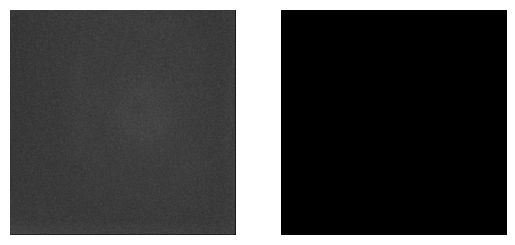

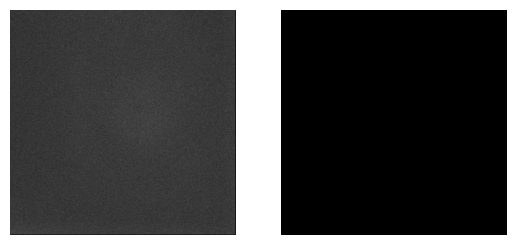

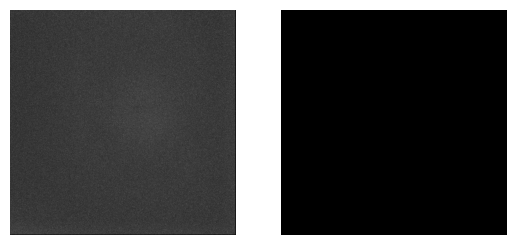

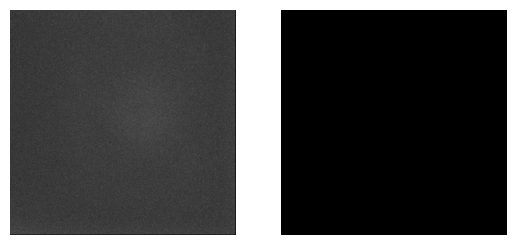

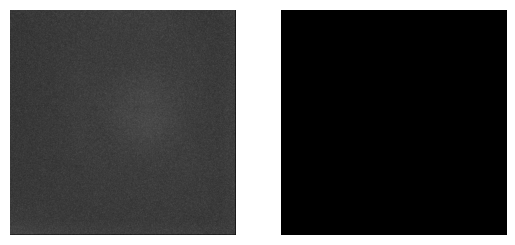

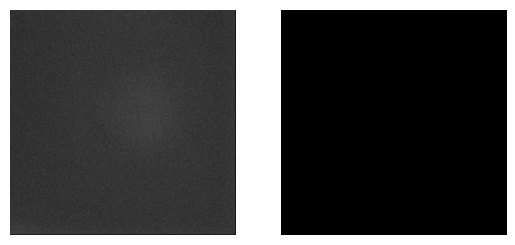

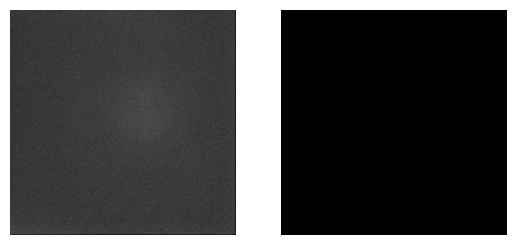

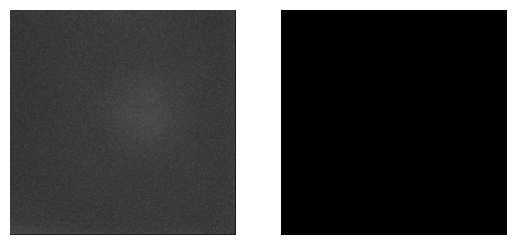

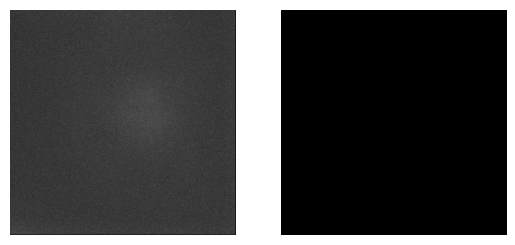

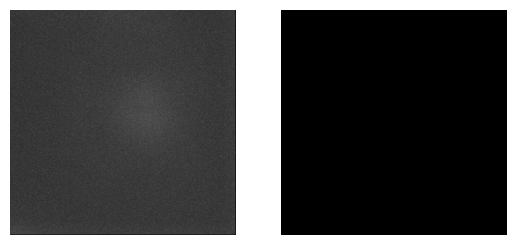

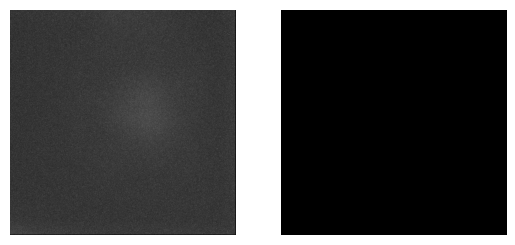

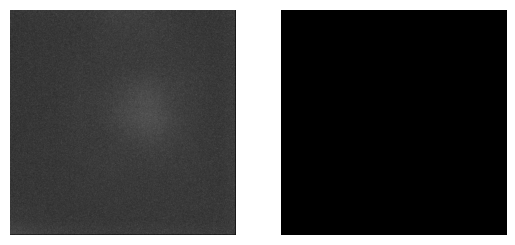

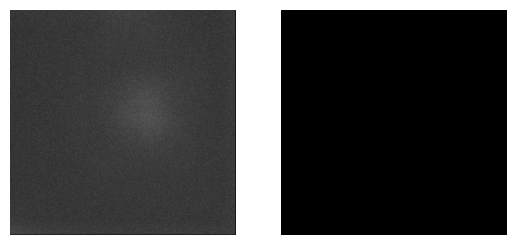

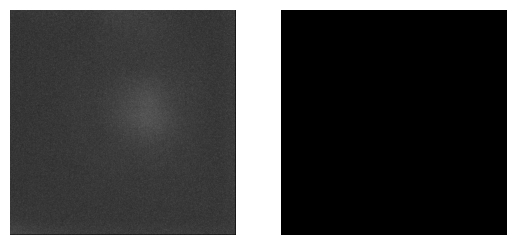

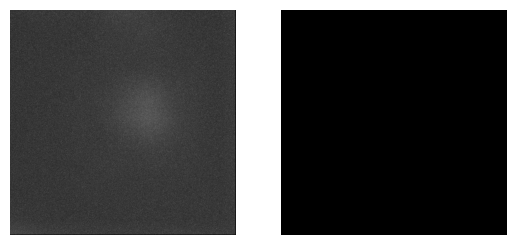

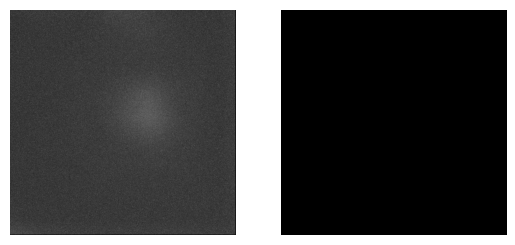

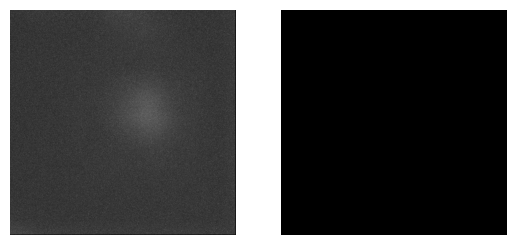

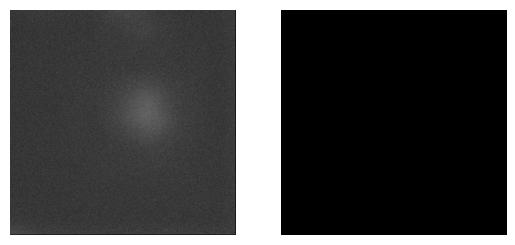

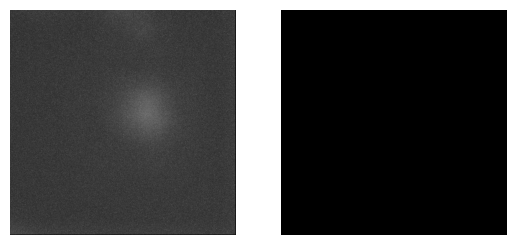

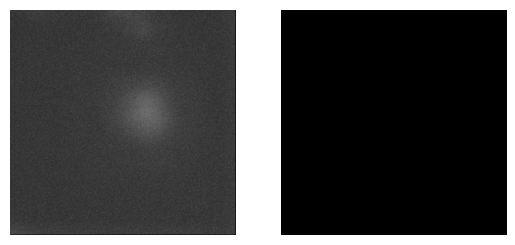

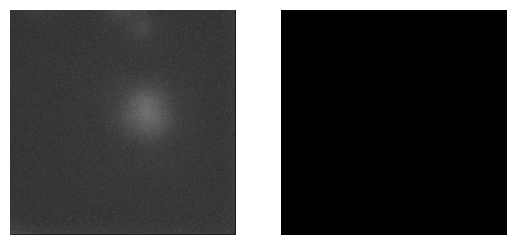

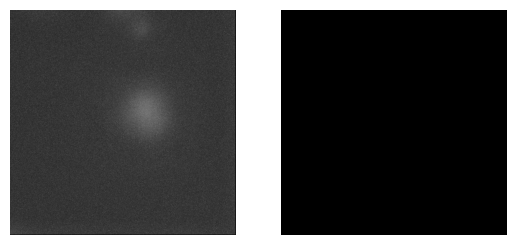

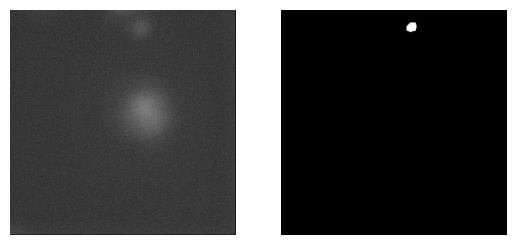

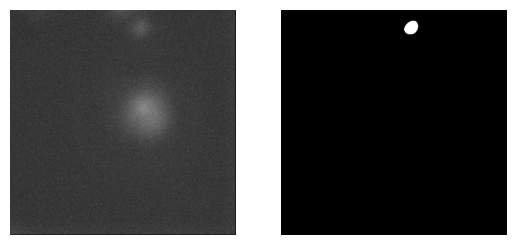

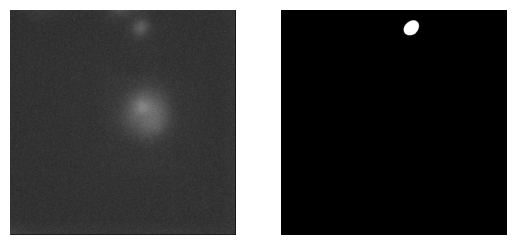

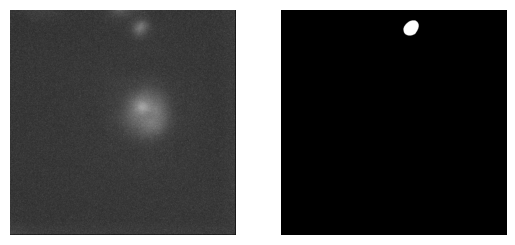

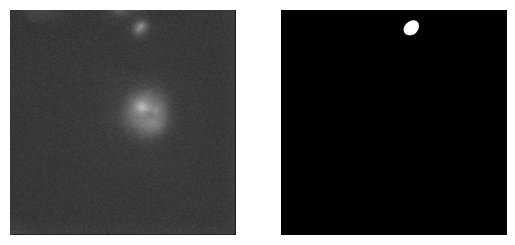

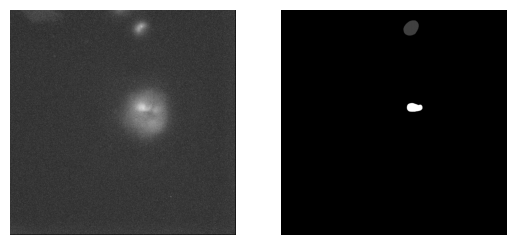

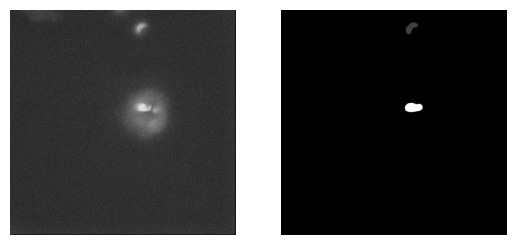

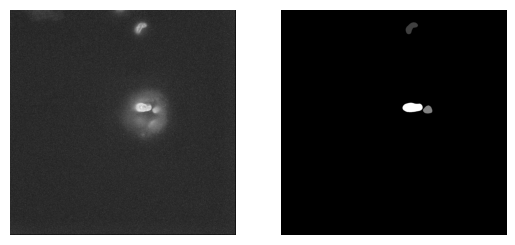

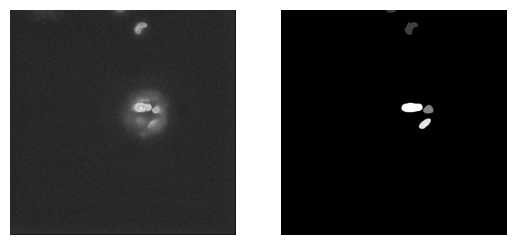

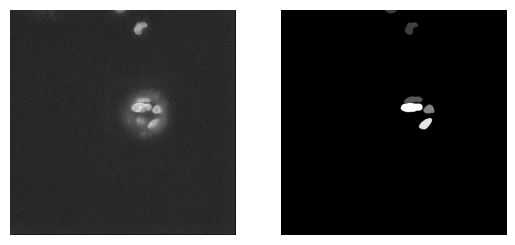

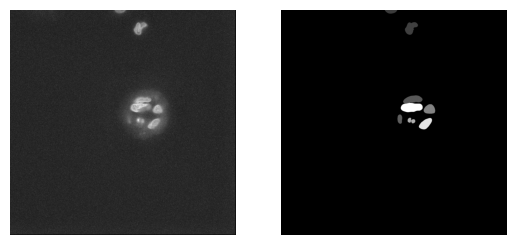

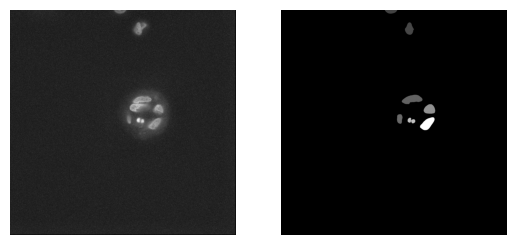

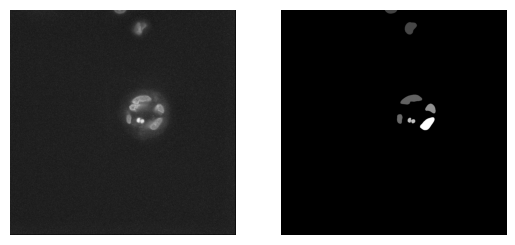

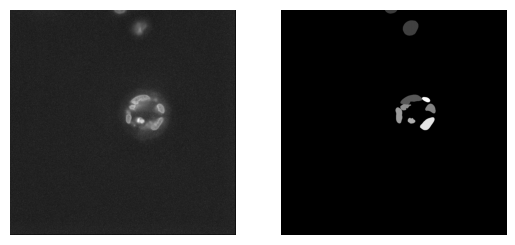

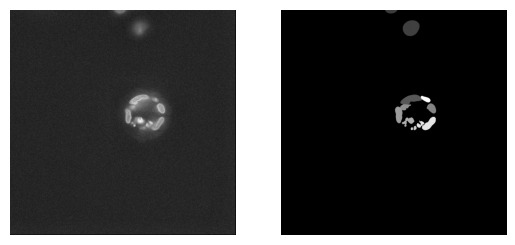

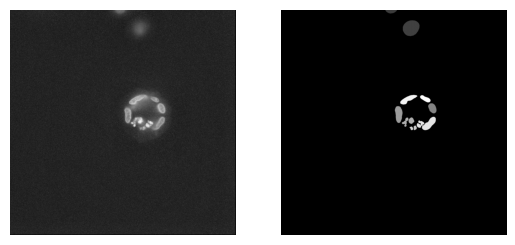

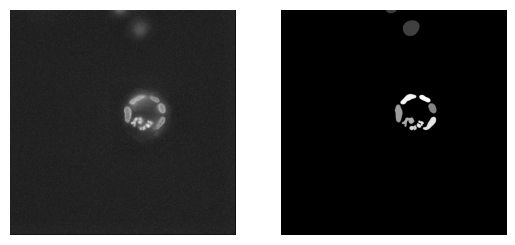

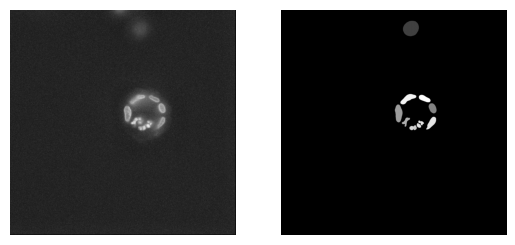

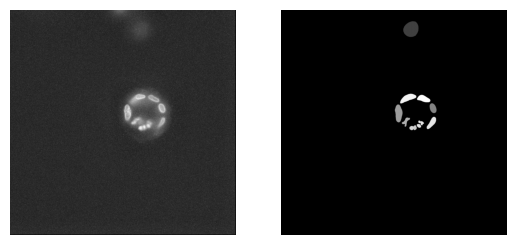

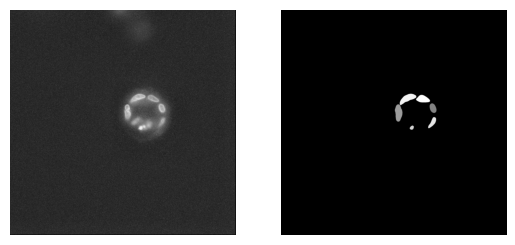

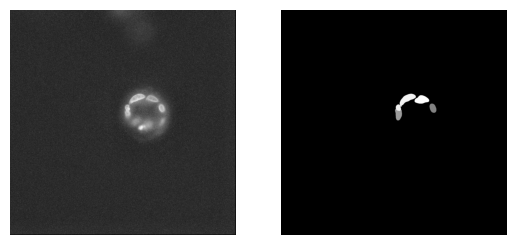

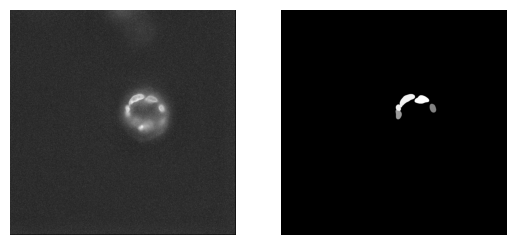

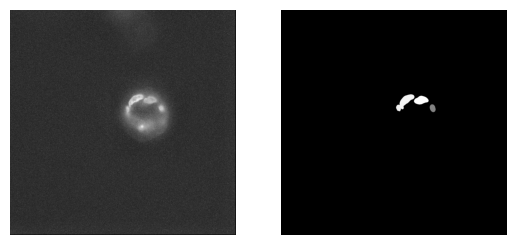

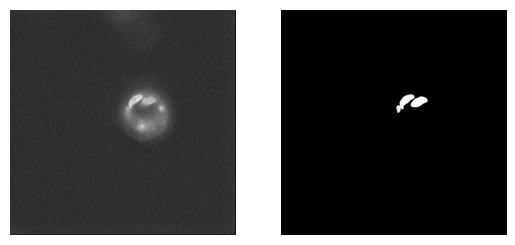

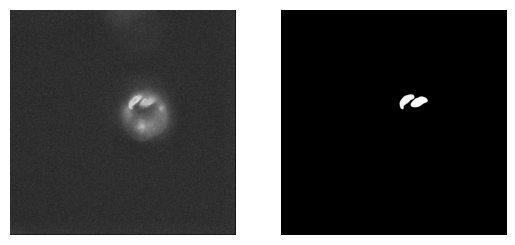

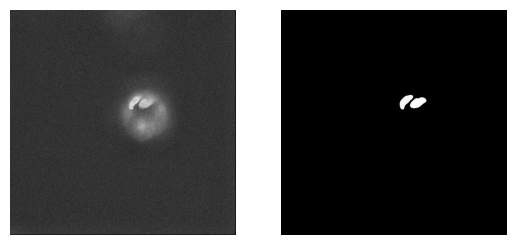

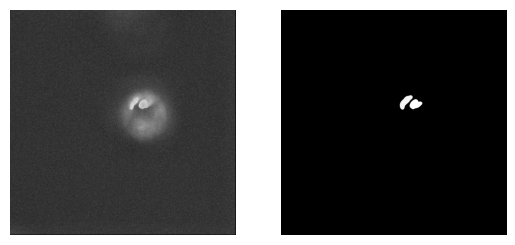

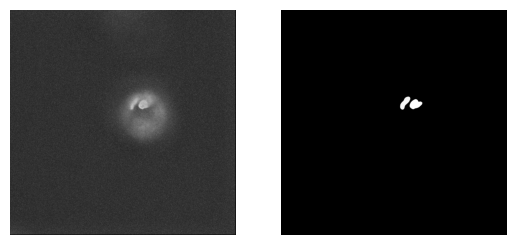

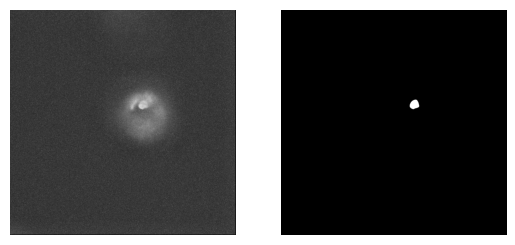

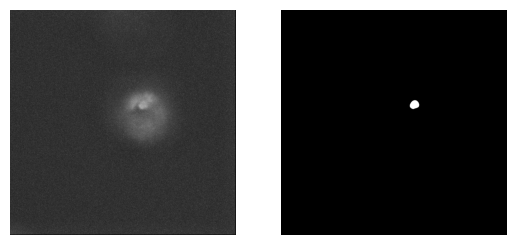

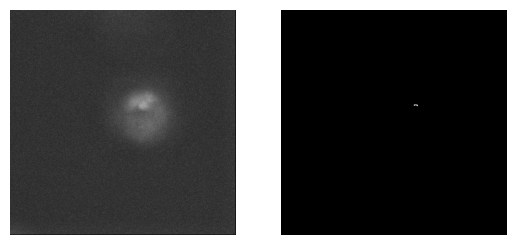

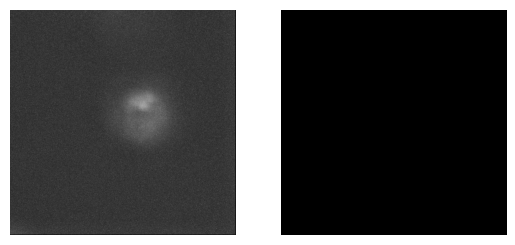

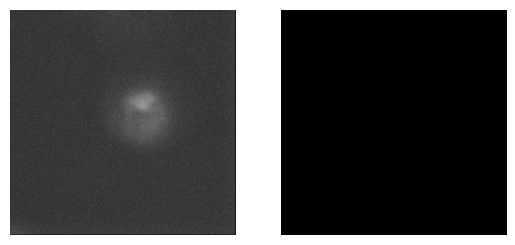

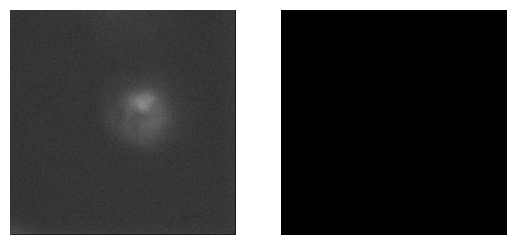

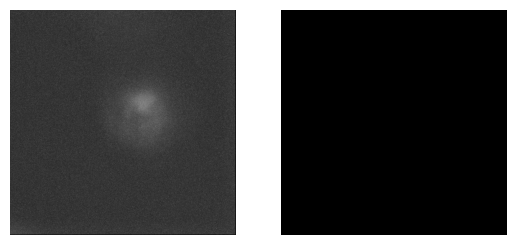

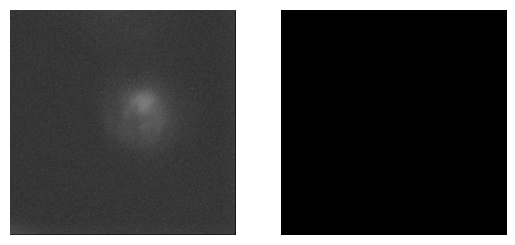

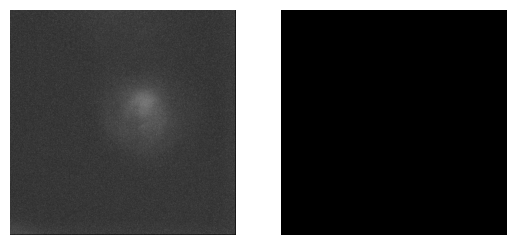

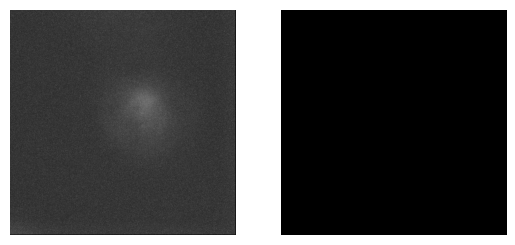

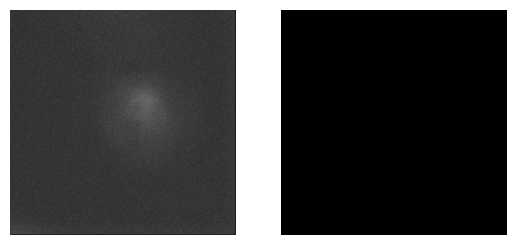

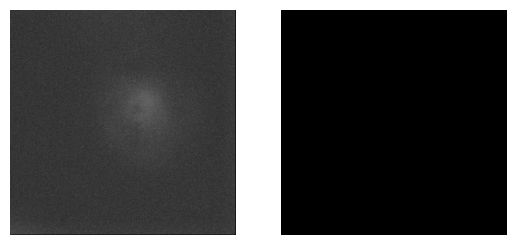

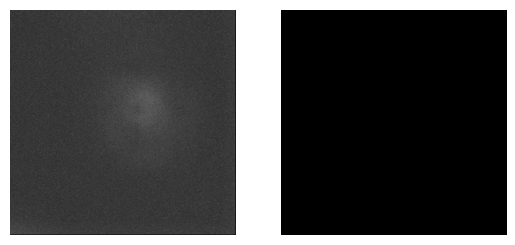

In [8]:
for zidx in range(nuclei_mask.shape[0]):
    plt.subplot(121)
    plt.imshow(nuclei[zidx, :, :], cmap="gray")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(nuclei_mask[zidx, :, :], cmap="gray")
    plt.axis("off")
    plt.show()

## run the mask reassignment function (post-hoc)
### This needs to occur after both nuclei and cell segmentations are done

In [9]:
nuclei_df = get_labels_for_post_hoc_reassignment(
    compartment_mask=nuclei_mask, compartment_name="nuclei"
)

## Save the segmented masks

In [10]:
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
tifffile.imwrite(nuclei_mask_output, nuclei_mask)

In [11]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
print(f"""
    Memory and time profiling for the run:\n
    Memory usage: {end_mem - start_mem:.2f} MB\n
    Time:\n
    --- %s seconds --- % {(end_time - start_time)}\n
    --- %s minutes --- % {((end_time - start_time) / 60)}\n
    --- %s hours --- % {((end_time - start_time) / 3600)}
""")


    Memory and time profiling for the run:

    Memory usage: 6138.75 MB

    Time:

    --- %s seconds --- % 219.21041703224182

    --- %s minutes --- % 3.6535069505373636

    --- %s hours --- % 0.06089178250895606

